# Implementation of Vanilla GANs model with Gaussian dataset
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.autograd as autograd

import numpy as np
import datetime
import os, sys
import random

random.seed(42)
np.random.seed(42)

from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")
DATASET = 'swissroll'
NO_OF_BATCHES = 1000
BATCH_SIZE = 64
max_epoch = 100 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 2

In [4]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [5]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=2):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [6]:
def generate_image(dist):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    for idx in range(NO_OF_BATCHES):
        plt.scatter(dist[idx][:,0], dist[idx][:,1], c='blue', marker='+')

    z = torch.randn(BATCH_SIZE*NO_OF_BATCHES, n_noise).to(DEVICE)
    z_outputs = G(z)
    
    z_outputs = z_outputs.cpu().detach().numpy()
    
    plt.scatter(z_outputs[:,0], z_outputs[:,1], c='red', marker='+')
    plt.show()

In [7]:
def inf_train_gen():
    if DATASET == '25gaussians':

        dataset = []
        for i in range(int(100000 / 25)):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = np.random.randn(2) * 0.05
                    point[0] += 2 * x
                    point[1] += 2 * y
                    dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        np.random.shuffle(dataset)
        dataset /= 2.828  # stdev
        while True:
            for i in range(int(len(dataset) / BATCH_SIZE)):
                yield dataset[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE,
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5  # stdev plus a little
            yield data

    elif DATASET == '8gaussians':

        scale = 2.
        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) for x, y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = np.random.randn(2) * .02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = np.array(dataset, dtype='float32')
            dataset /= 1.414  # stdev
            yield dataset


In [8]:


D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
D_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to fake

data = inf_train_gen()

train = []

for _ in range(NO_OF_BATCHES):
    data_ = next(data)
    train.append(data_)

train = np.array(train)

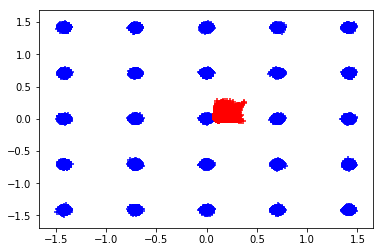

In [10]:
generate_image(train)

Epoch: 0/100, Step: 0, D Loss: 1.373038411140442, G Loss: 0.6866488456726074


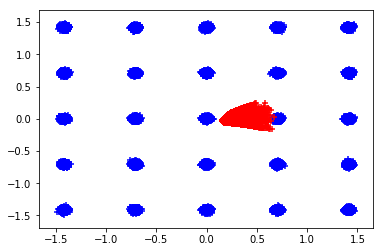

Epoch: 0/100, Step: 500, D Loss: 1.1474813222885132, G Loss: 0.881533145904541


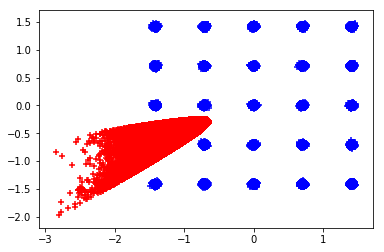

Epoch: 1/100, Step: 1000, D Loss: 1.2202929258346558, G Loss: 1.0310193300247192


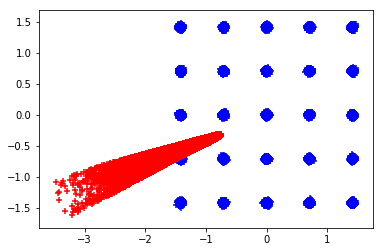

Epoch: 1/100, Step: 1500, D Loss: 1.4781489372253418, G Loss: 0.705559492111206


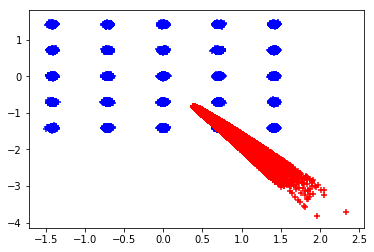

Epoch: 2/100, Step: 2000, D Loss: 1.5206915140151978, G Loss: 0.724704921245575


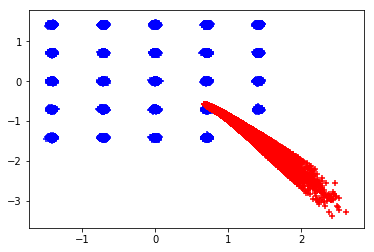

Epoch: 2/100, Step: 2500, D Loss: 1.5052422285079956, G Loss: 0.7740083932876587


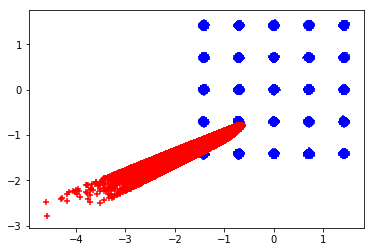

Epoch: 3/100, Step: 3000, D Loss: 1.2426669597625732, G Loss: 0.8051977753639221


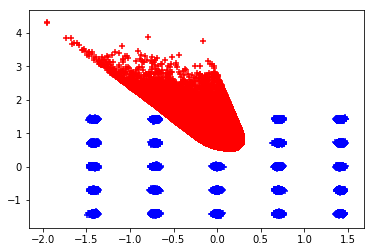

Epoch: 3/100, Step: 3500, D Loss: 1.8273303508758545, G Loss: 0.5185742378234863


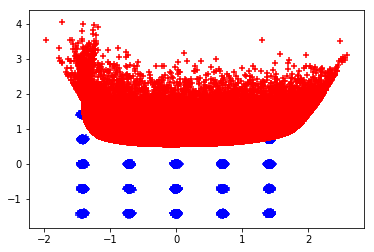

Epoch: 4/100, Step: 4000, D Loss: 1.120169997215271, G Loss: 0.9563076496124268


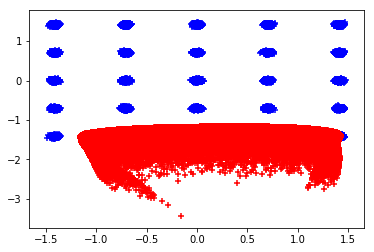

Epoch: 4/100, Step: 4500, D Loss: 1.7564337253570557, G Loss: 0.5475576519966125


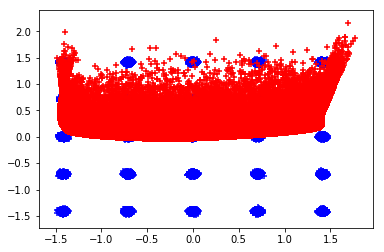

Epoch: 5/100, Step: 5000, D Loss: 0.9730788469314575, G Loss: 0.9451421499252319


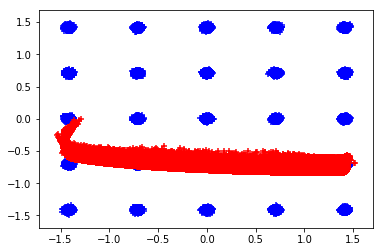

Epoch: 5/100, Step: 5500, D Loss: 1.3476076126098633, G Loss: 1.0659313201904297


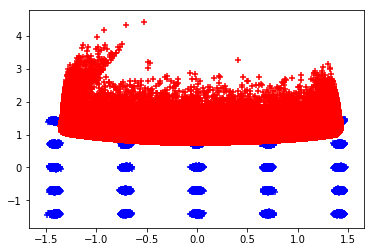

Epoch: 6/100, Step: 6000, D Loss: 1.3454906940460205, G Loss: 0.6774597764015198


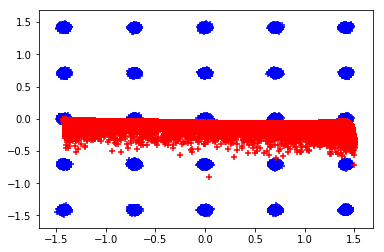

Epoch: 6/100, Step: 6500, D Loss: 1.3056719303131104, G Loss: 0.675983726978302


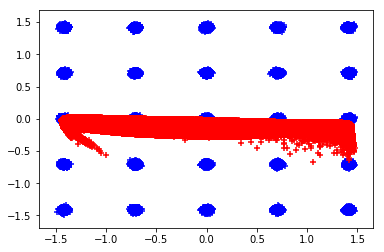

Epoch: 7/100, Step: 7000, D Loss: 1.3684474229812622, G Loss: 1.1056573390960693


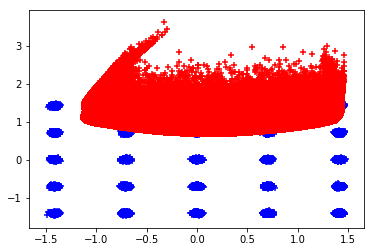

Epoch: 7/100, Step: 7500, D Loss: 1.382146954536438, G Loss: 0.59715735912323


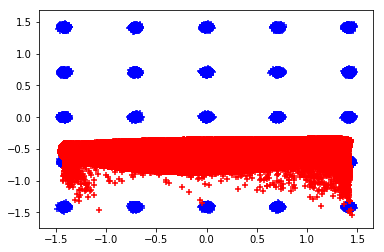

Epoch: 8/100, Step: 8000, D Loss: 1.4846274852752686, G Loss: 0.5553745627403259


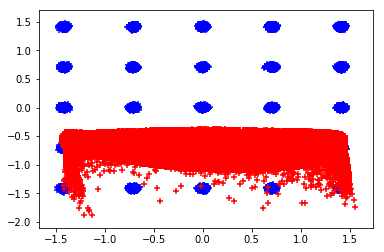

Epoch: 8/100, Step: 8500, D Loss: 1.2914832830429077, G Loss: 0.7798099517822266


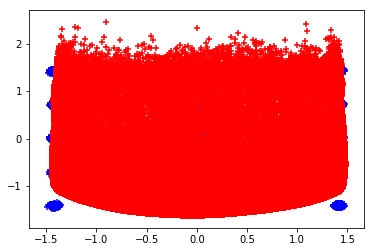

Epoch: 9/100, Step: 9000, D Loss: 1.2541228532791138, G Loss: 0.7730220556259155


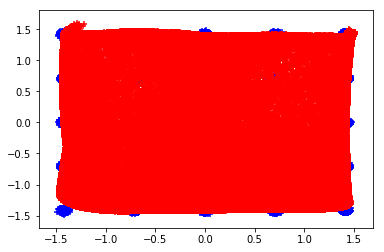

Epoch: 9/100, Step: 9500, D Loss: 1.275943398475647, G Loss: 0.7942790389060974


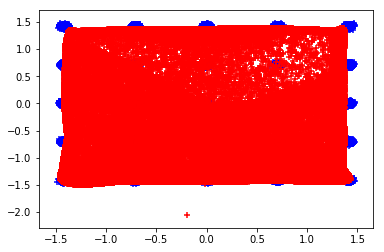

Epoch: 10/100, Step: 10000, D Loss: 1.2419085502624512, G Loss: 0.8057065606117249


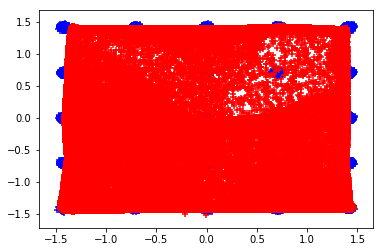

Epoch: 10/100, Step: 10500, D Loss: 1.1979575157165527, G Loss: 0.8018693327903748


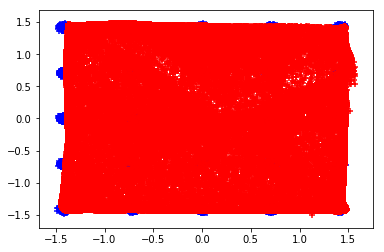

Epoch: 11/100, Step: 11000, D Loss: 1.1058733463287354, G Loss: 0.8801891803741455


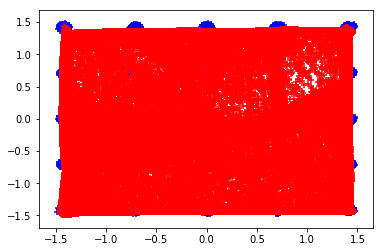

Epoch: 11/100, Step: 11500, D Loss: 1.0142148733139038, G Loss: 0.9375903606414795


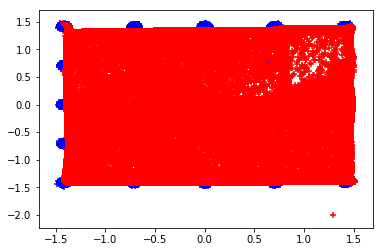

Epoch: 12/100, Step: 12000, D Loss: 1.0456463098526, G Loss: 1.0262870788574219


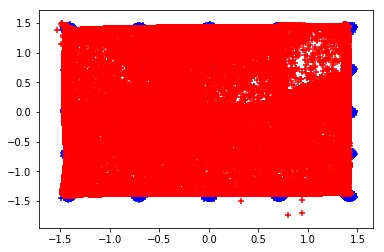

Epoch: 12/100, Step: 12500, D Loss: 0.9654354453086853, G Loss: 1.1876158714294434


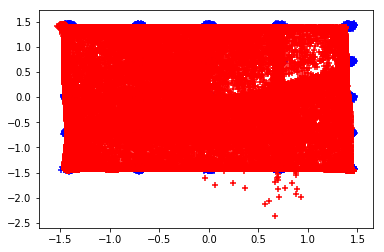

Epoch: 13/100, Step: 13000, D Loss: 0.915971577167511, G Loss: 1.068490982055664


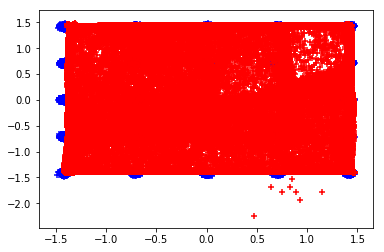

Epoch: 13/100, Step: 13500, D Loss: 0.9196600317955017, G Loss: 1.1955101490020752


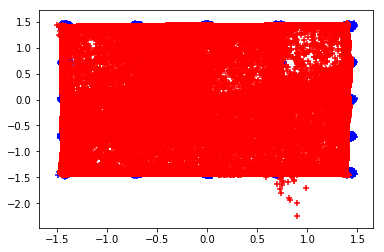

Epoch: 14/100, Step: 14000, D Loss: 0.9373844861984253, G Loss: 1.2512011528015137


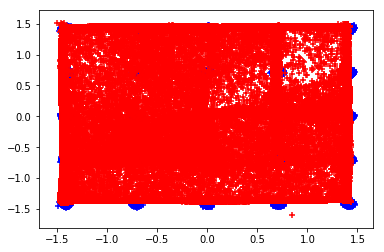

Epoch: 14/100, Step: 14500, D Loss: 0.7811083197593689, G Loss: 1.371323585510254


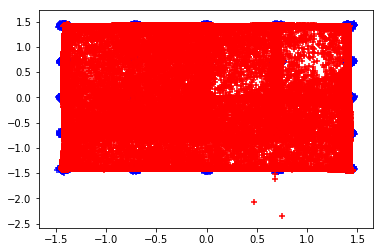

Epoch: 15/100, Step: 15000, D Loss: 0.8567928075790405, G Loss: 1.5710169076919556


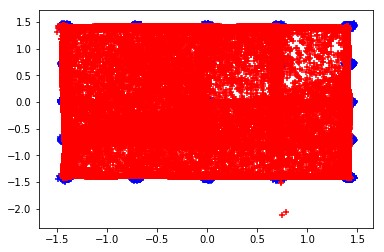

Epoch: 15/100, Step: 15500, D Loss: 0.9263504147529602, G Loss: 1.5556923151016235


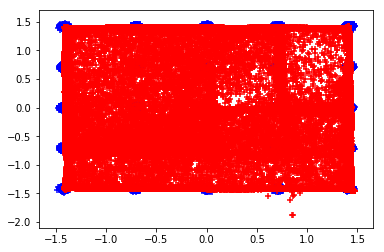

Epoch: 16/100, Step: 16000, D Loss: 0.8229845762252808, G Loss: 1.531705379486084


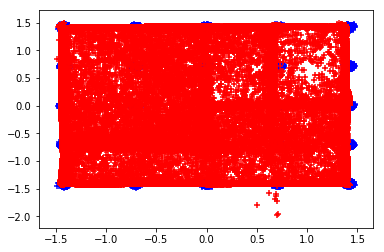

Epoch: 16/100, Step: 16500, D Loss: 0.9137433767318726, G Loss: 1.579389214515686


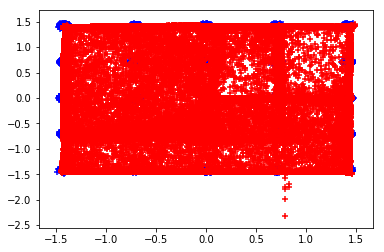

Epoch: 17/100, Step: 17000, D Loss: 0.832147479057312, G Loss: 1.5153040885925293


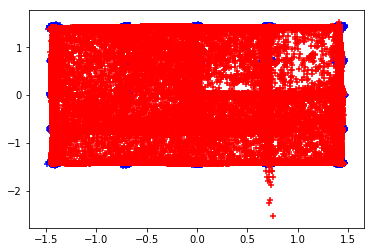

Epoch: 17/100, Step: 17500, D Loss: 0.8113119006156921, G Loss: 1.8202040195465088


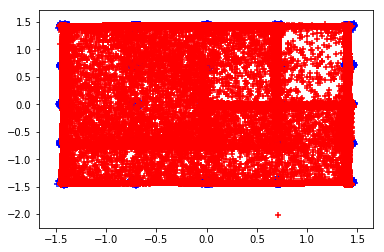

Epoch: 18/100, Step: 18000, D Loss: 0.8390432596206665, G Loss: 1.4322142601013184


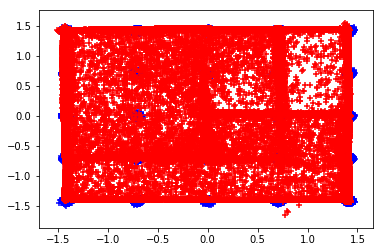

Epoch: 18/100, Step: 18500, D Loss: 0.7717301249504089, G Loss: 1.566695213317871


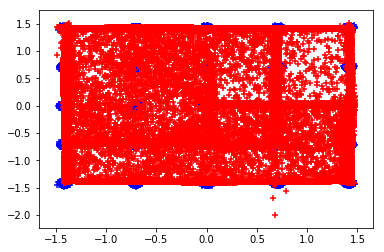

Epoch: 19/100, Step: 19000, D Loss: 0.9112380146980286, G Loss: 1.5439203977584839


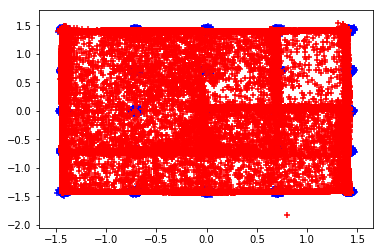

Epoch: 19/100, Step: 19500, D Loss: 0.9721761345863342, G Loss: 1.6749076843261719


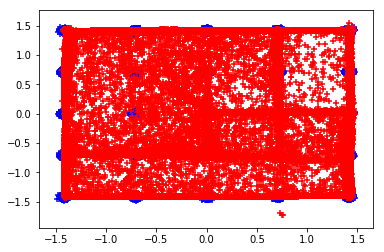

Epoch: 20/100, Step: 20000, D Loss: 0.8506220579147339, G Loss: 1.690657615661621


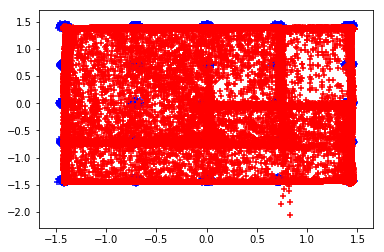

Epoch: 20/100, Step: 20500, D Loss: 0.9157906770706177, G Loss: 1.7555499076843262


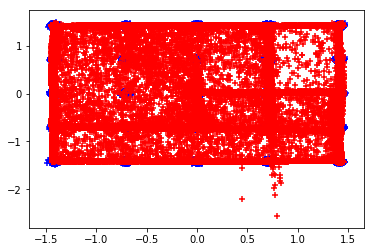

Epoch: 21/100, Step: 21000, D Loss: 0.9224036931991577, G Loss: 1.5535368919372559


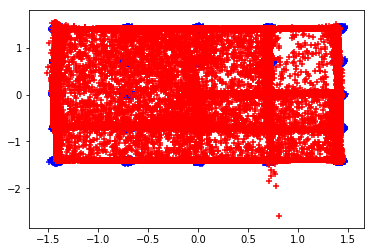

Epoch: 21/100, Step: 21500, D Loss: 0.8187546133995056, G Loss: 1.6461281776428223


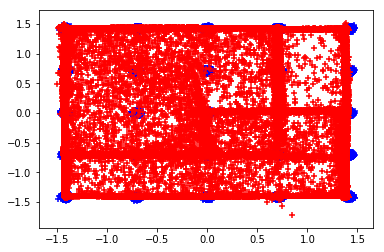

Epoch: 22/100, Step: 22000, D Loss: 0.9111003875732422, G Loss: 1.6202359199523926


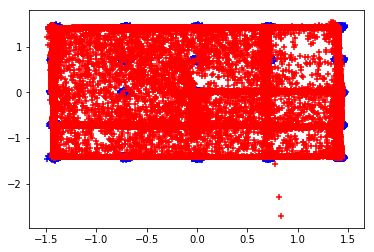

Epoch: 22/100, Step: 22500, D Loss: 0.8969060182571411, G Loss: 1.80039644241333


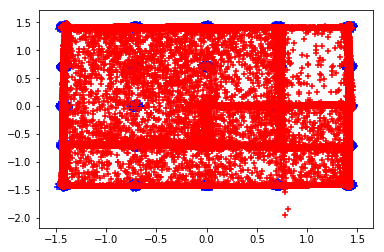

Epoch: 23/100, Step: 23000, D Loss: 0.8520137667655945, G Loss: 1.7200305461883545


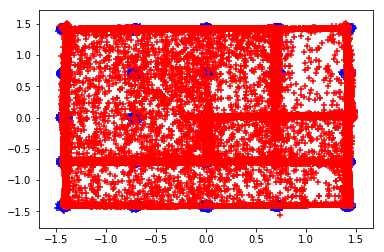

Epoch: 23/100, Step: 23500, D Loss: 0.9264277219772339, G Loss: 1.4195173978805542


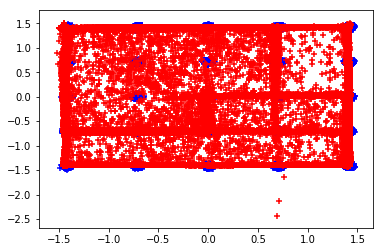

Epoch: 24/100, Step: 24000, D Loss: 0.8132274150848389, G Loss: 1.3535425662994385


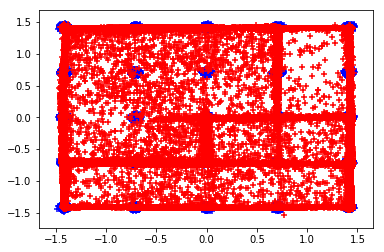

Epoch: 24/100, Step: 24500, D Loss: 0.8623125553131104, G Loss: 1.5871872901916504


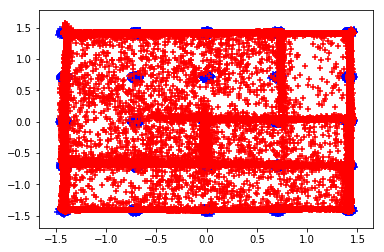

Epoch: 25/100, Step: 25000, D Loss: 0.7755162119865417, G Loss: 1.5909560918807983


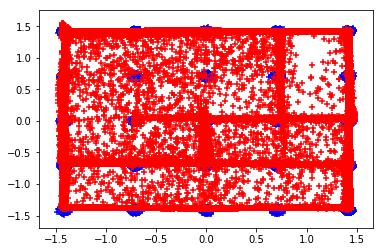

Epoch: 25/100, Step: 25500, D Loss: 0.8220407962799072, G Loss: 1.7615472078323364


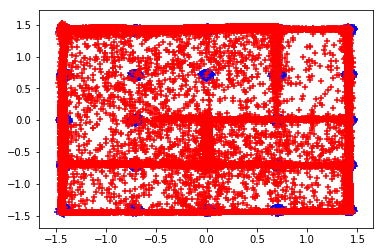

Epoch: 26/100, Step: 26000, D Loss: 0.8597935438156128, G Loss: 1.6994023323059082


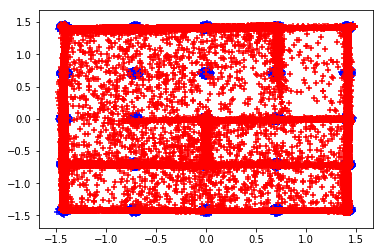

Epoch: 26/100, Step: 26500, D Loss: 0.9867926836013794, G Loss: 1.7249672412872314


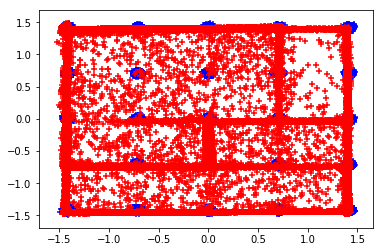

Epoch: 27/100, Step: 27000, D Loss: 0.8260730504989624, G Loss: 1.7960004806518555


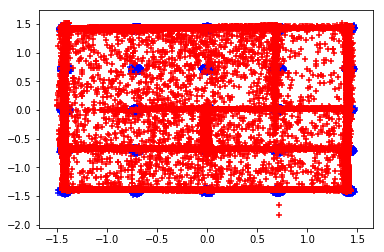

Epoch: 27/100, Step: 27500, D Loss: 1.0788424015045166, G Loss: 1.7412554025650024


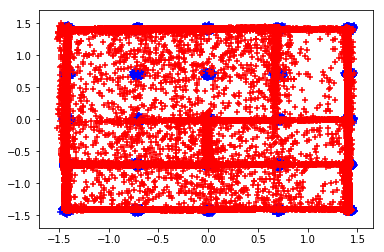

Epoch: 28/100, Step: 28000, D Loss: 0.8971238136291504, G Loss: 1.7992470264434814


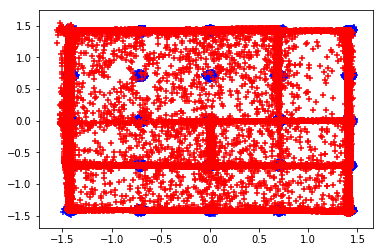

Epoch: 28/100, Step: 28500, D Loss: 0.8709589242935181, G Loss: 1.8663455247879028


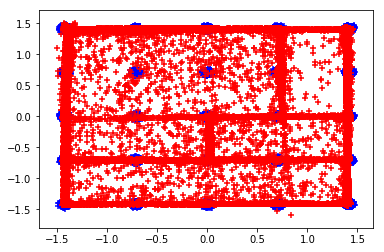

Epoch: 29/100, Step: 29000, D Loss: 0.9651059508323669, G Loss: 1.7370858192443848


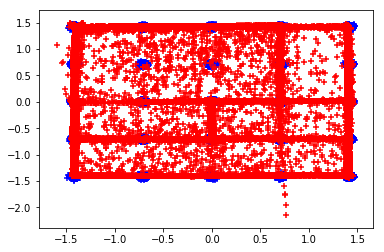

Epoch: 29/100, Step: 29500, D Loss: 1.0796208381652832, G Loss: 1.7011427879333496


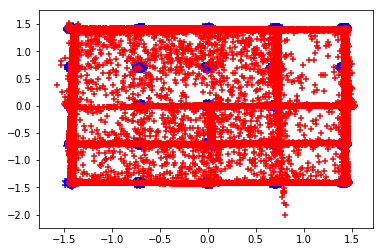

Epoch: 30/100, Step: 30000, D Loss: 0.8995199203491211, G Loss: 1.3566663265228271


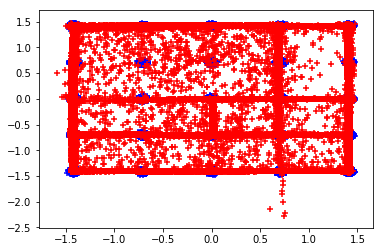

Epoch: 30/100, Step: 30500, D Loss: 0.9021042585372925, G Loss: 1.8294992446899414


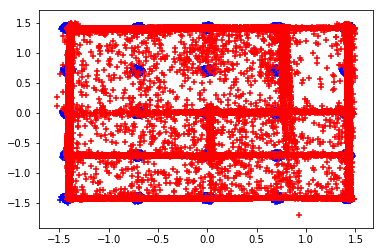

Epoch: 31/100, Step: 31000, D Loss: 0.9106855392456055, G Loss: 1.642638921737671


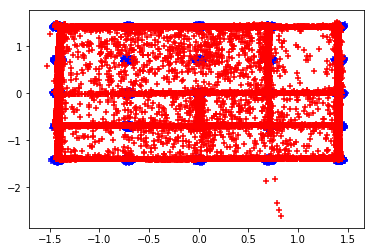

Epoch: 31/100, Step: 31500, D Loss: 0.851527750492096, G Loss: 1.709862470626831


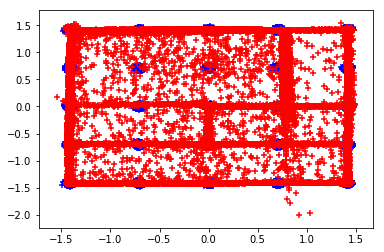

Epoch: 32/100, Step: 32000, D Loss: 0.8780813813209534, G Loss: 1.921212077140808


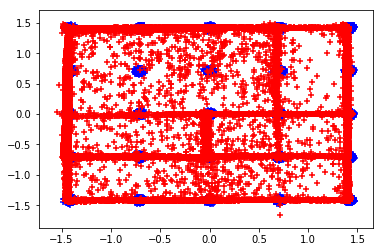

Epoch: 32/100, Step: 32500, D Loss: 0.9004369974136353, G Loss: 1.3546838760375977


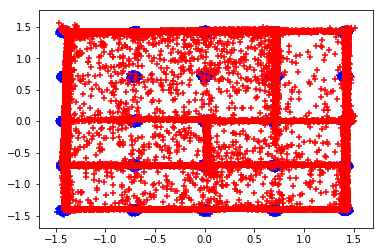

Epoch: 33/100, Step: 33000, D Loss: 0.7768685817718506, G Loss: 1.6315727233886719


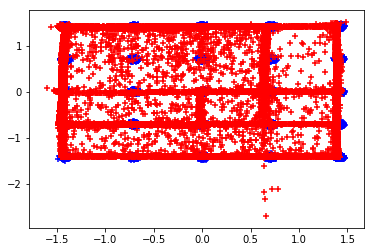

Epoch: 33/100, Step: 33500, D Loss: 0.8396183252334595, G Loss: 1.8008325099945068


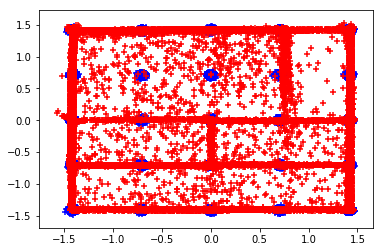

Epoch: 34/100, Step: 34000, D Loss: 0.8771573305130005, G Loss: 1.374800205230713


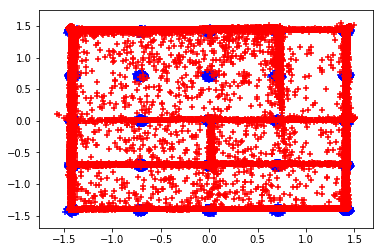

Epoch: 34/100, Step: 34500, D Loss: 1.0401637554168701, G Loss: 1.53490149974823


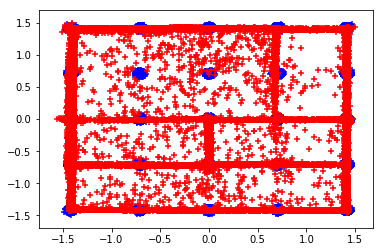

Epoch: 35/100, Step: 35000, D Loss: 0.9546328186988831, G Loss: 1.709801197052002


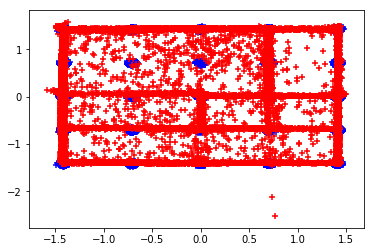

Epoch: 35/100, Step: 35500, D Loss: 0.9517636895179749, G Loss: 1.5772757530212402


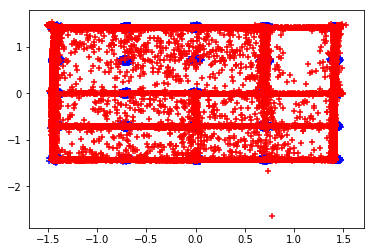

Epoch: 36/100, Step: 36000, D Loss: 0.8815094232559204, G Loss: 1.948228359222412


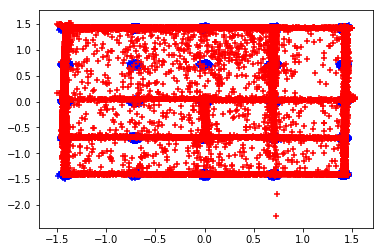

Epoch: 36/100, Step: 36500, D Loss: 1.0104780197143555, G Loss: 1.6731412410736084


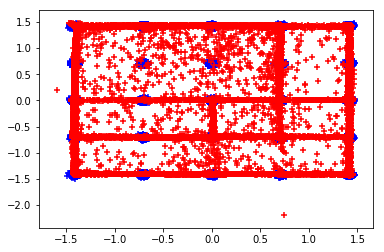

Epoch: 37/100, Step: 37000, D Loss: 0.9066915512084961, G Loss: 1.681067943572998


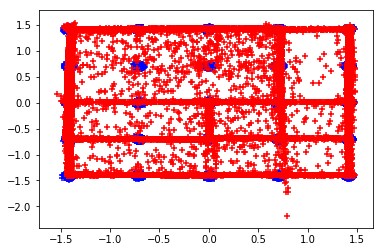

Epoch: 37/100, Step: 37500, D Loss: 0.9317210912704468, G Loss: 1.3960840702056885


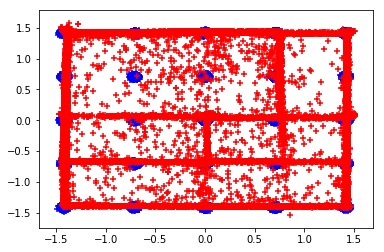

Epoch: 38/100, Step: 38000, D Loss: 0.8275092840194702, G Loss: 1.6795599460601807


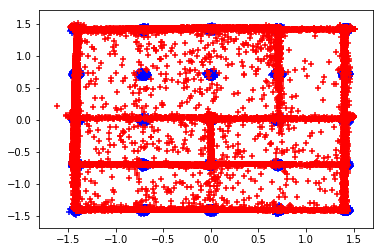

Epoch: 38/100, Step: 38500, D Loss: 0.831253170967102, G Loss: 1.5792791843414307


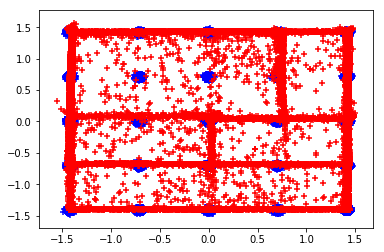

Epoch: 39/100, Step: 39000, D Loss: 0.7873110771179199, G Loss: 1.3263936042785645


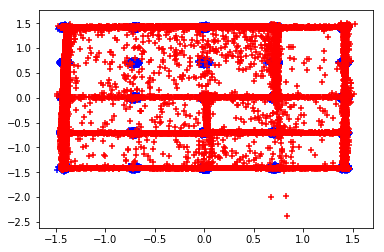

Epoch: 39/100, Step: 39500, D Loss: 0.9366936683654785, G Loss: 1.436338186264038


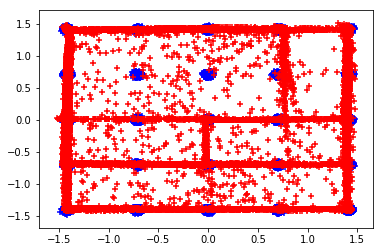

Epoch: 40/100, Step: 40000, D Loss: 0.7921184301376343, G Loss: 1.5778255462646484


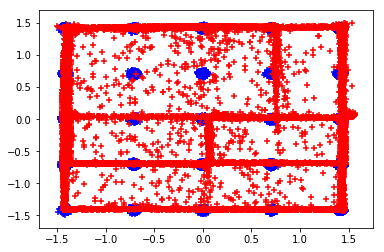

Epoch: 40/100, Step: 40500, D Loss: 0.8958410620689392, G Loss: 1.5761092901229858


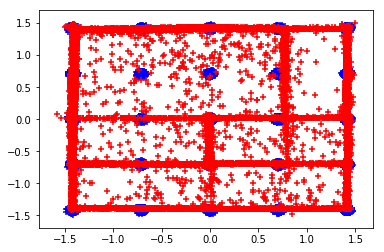

Epoch: 41/100, Step: 41000, D Loss: 0.9833958745002747, G Loss: 1.854475498199463


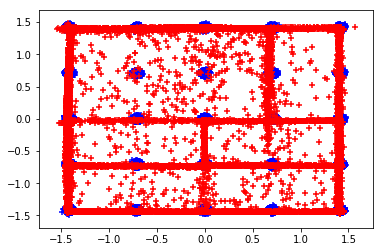

Epoch: 41/100, Step: 41500, D Loss: 0.8990307450294495, G Loss: 1.3977291584014893


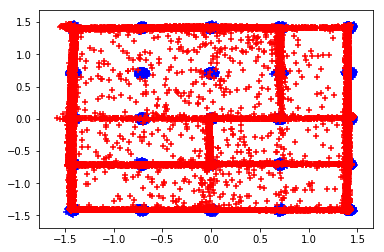

Epoch: 42/100, Step: 42000, D Loss: 0.8604004383087158, G Loss: 1.67689847946167


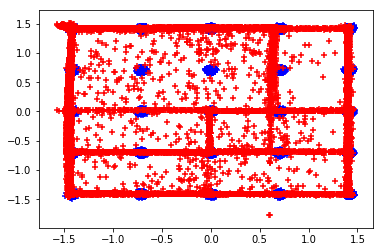

Epoch: 42/100, Step: 42500, D Loss: 0.9528864026069641, G Loss: 1.4738390445709229


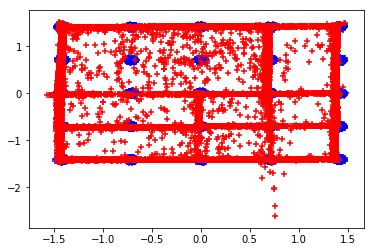

Epoch: 43/100, Step: 43000, D Loss: 0.8892709016799927, G Loss: 1.5655714273452759


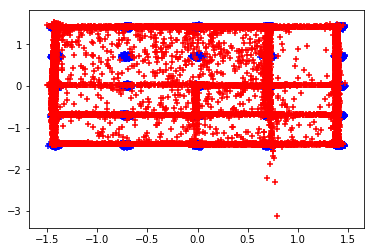

Epoch: 43/100, Step: 43500, D Loss: 0.8643808960914612, G Loss: 1.6760532855987549


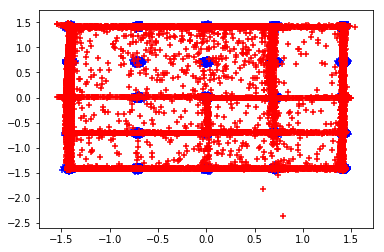

Epoch: 44/100, Step: 44000, D Loss: 0.9168224930763245, G Loss: 1.5946742296218872


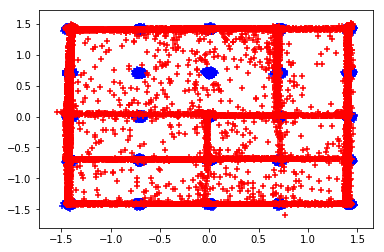

Epoch: 44/100, Step: 44500, D Loss: 0.9278759956359863, G Loss: 1.5743517875671387


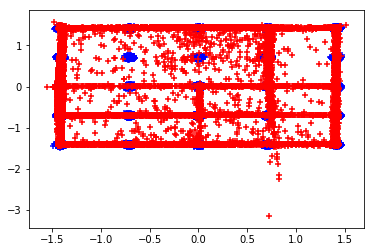

Epoch: 45/100, Step: 45000, D Loss: 0.8890209197998047, G Loss: 1.5862959623336792


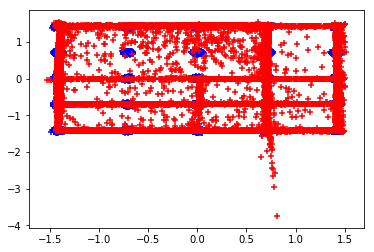

Epoch: 45/100, Step: 45500, D Loss: 0.9466807246208191, G Loss: 1.2901339530944824


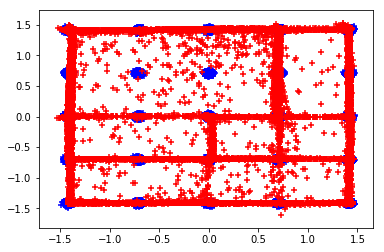

Epoch: 46/100, Step: 46000, D Loss: 0.900370717048645, G Loss: 1.774298906326294


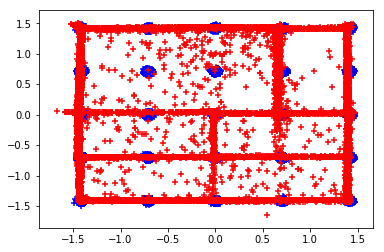

Epoch: 46/100, Step: 46500, D Loss: 0.9273523092269897, G Loss: 1.4921038150787354


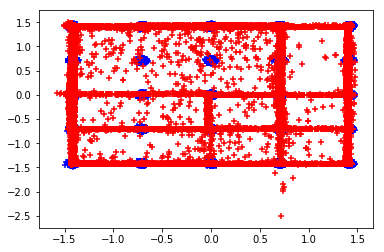

Epoch: 47/100, Step: 47000, D Loss: 0.922469437122345, G Loss: 1.8233089447021484


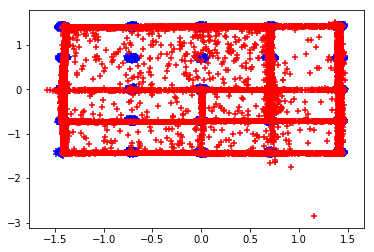

Epoch: 47/100, Step: 47500, D Loss: 0.9535626173019409, G Loss: 1.3716005086898804


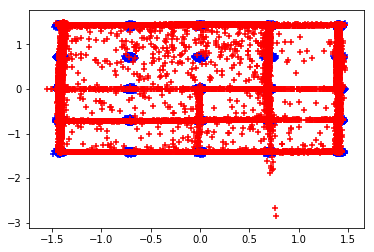

Epoch: 48/100, Step: 48000, D Loss: 0.91083824634552, G Loss: 1.9830522537231445


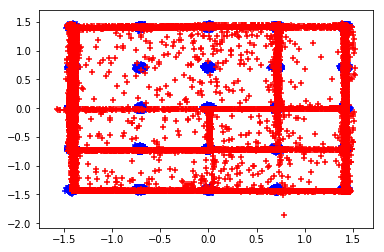

Epoch: 48/100, Step: 48500, D Loss: 0.8733478784561157, G Loss: 1.3108930587768555


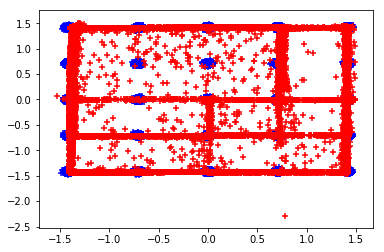

Epoch: 49/100, Step: 49000, D Loss: 1.0152716636657715, G Loss: 1.33219575881958


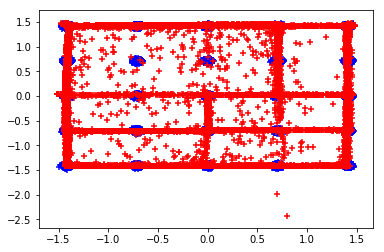

Epoch: 49/100, Step: 49500, D Loss: 0.9193434715270996, G Loss: 1.441049575805664


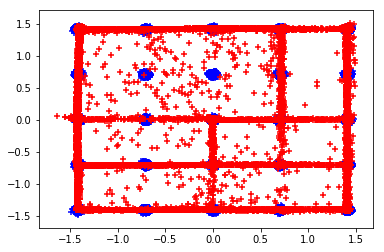

Epoch: 50/100, Step: 50000, D Loss: 0.9008792638778687, G Loss: 1.281505823135376


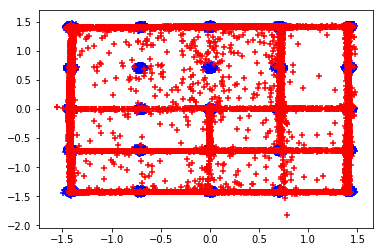

Epoch: 50/100, Step: 50500, D Loss: 0.9738531112670898, G Loss: 1.3605238199234009


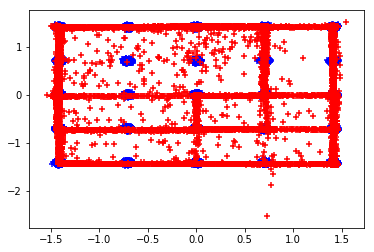

Epoch: 51/100, Step: 51000, D Loss: 0.9814735651016235, G Loss: 1.737486720085144


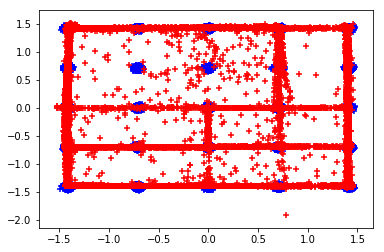

Epoch: 51/100, Step: 51500, D Loss: 0.9326297044754028, G Loss: 1.4443117380142212


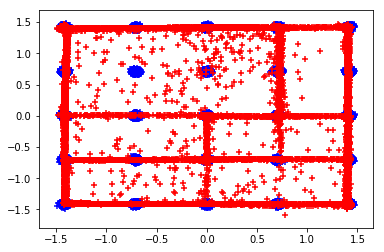

Epoch: 52/100, Step: 52000, D Loss: 0.8836082816123962, G Loss: 1.6089262962341309


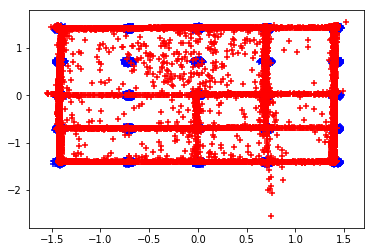

Epoch: 52/100, Step: 52500, D Loss: 0.9364017248153687, G Loss: 1.2878926992416382


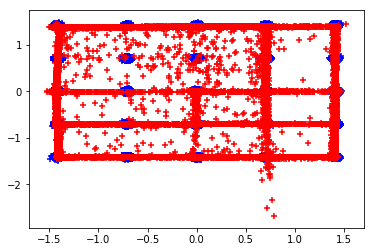

Epoch: 53/100, Step: 53000, D Loss: 0.8475961685180664, G Loss: 1.2982017993927002


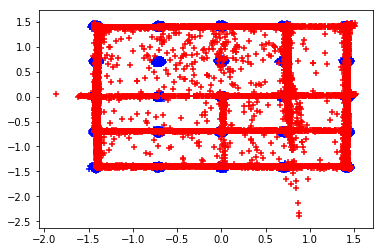

Epoch: 53/100, Step: 53500, D Loss: 0.896536648273468, G Loss: 1.4815008640289307


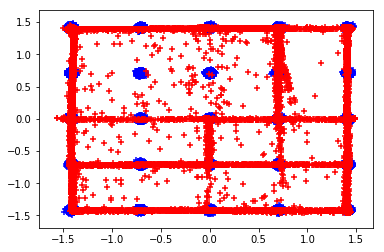

Epoch: 54/100, Step: 54000, D Loss: 0.9029577374458313, G Loss: 1.7538342475891113


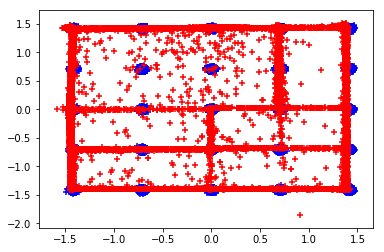

Epoch: 54/100, Step: 54500, D Loss: 0.9154151082038879, G Loss: 1.6619218587875366


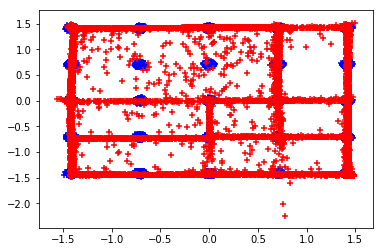

Epoch: 55/100, Step: 55000, D Loss: 0.9321677088737488, G Loss: 1.4900426864624023


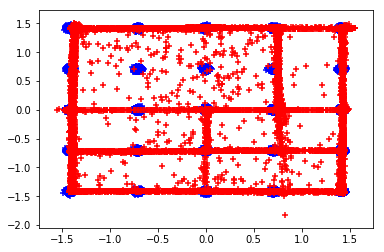

Epoch: 55/100, Step: 55500, D Loss: 0.9617990255355835, G Loss: 1.4201123714447021


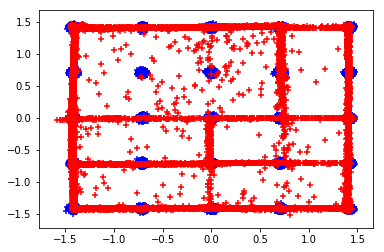

Epoch: 56/100, Step: 56000, D Loss: 0.913176417350769, G Loss: 1.4652032852172852


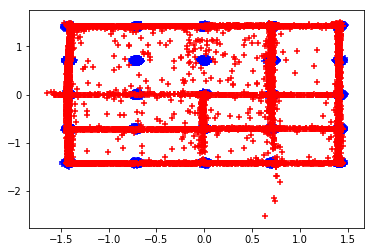

Epoch: 56/100, Step: 56500, D Loss: 1.0061428546905518, G Loss: 1.4965909719467163


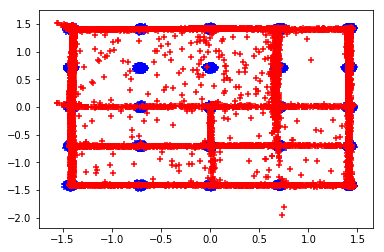

Epoch: 57/100, Step: 57000, D Loss: 1.0237348079681396, G Loss: 1.5307139158248901


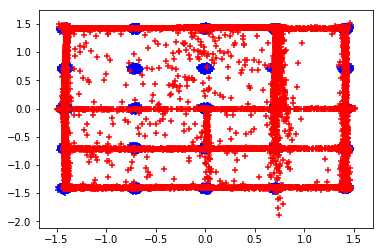

Epoch: 57/100, Step: 57500, D Loss: 0.9392693638801575, G Loss: 1.3470399379730225


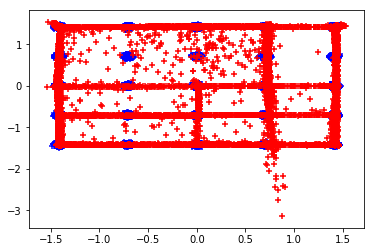

Epoch: 58/100, Step: 58000, D Loss: 0.8889504671096802, G Loss: 1.3925939798355103


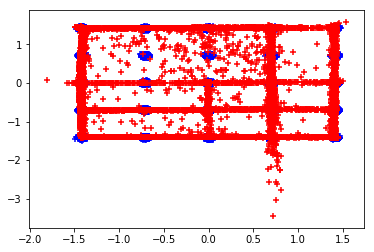

Epoch: 58/100, Step: 58500, D Loss: 0.9555690288543701, G Loss: 1.4986796379089355


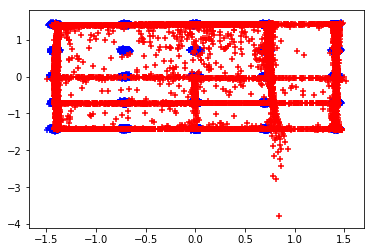

Epoch: 59/100, Step: 59000, D Loss: 0.9092408418655396, G Loss: 1.4033927917480469


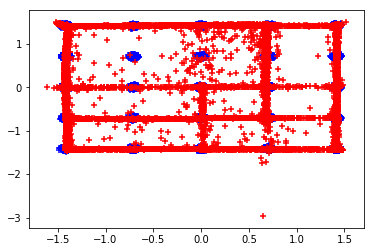

Epoch: 59/100, Step: 59500, D Loss: 0.9374420046806335, G Loss: 1.3973259925842285


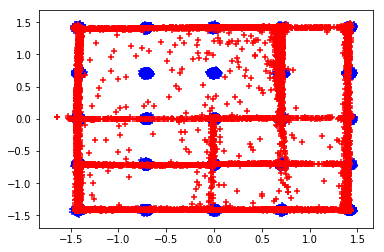

Epoch: 60/100, Step: 60000, D Loss: 0.8816895484924316, G Loss: 1.3958077430725098


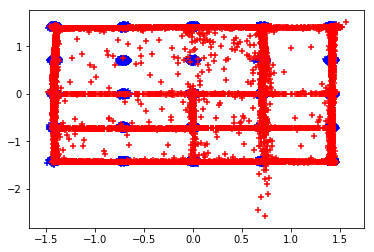

Epoch: 60/100, Step: 60500, D Loss: 0.8889298439025879, G Loss: 1.1690497398376465


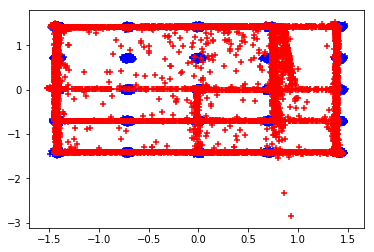

Epoch: 61/100, Step: 61000, D Loss: 0.9586212038993835, G Loss: 1.459615707397461


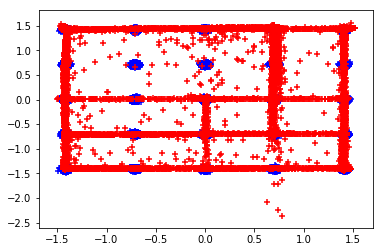

Epoch: 61/100, Step: 61500, D Loss: 0.8975407481193542, G Loss: 1.4539601802825928


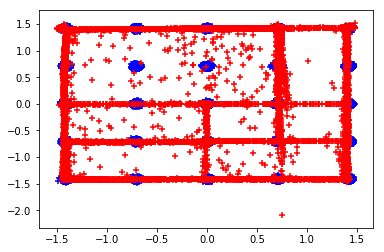

Epoch: 62/100, Step: 62000, D Loss: 0.9375367760658264, G Loss: 1.5647590160369873


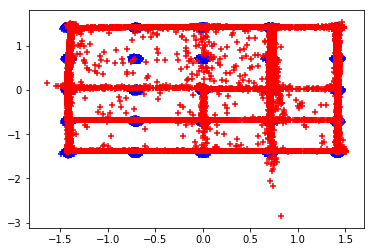

Epoch: 62/100, Step: 62500, D Loss: 1.04447340965271, G Loss: 1.780653476715088


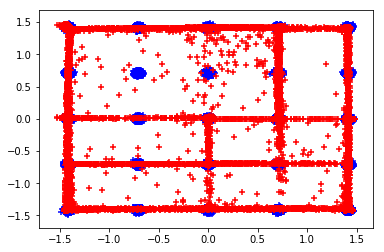

Epoch: 63/100, Step: 63000, D Loss: 0.9348222017288208, G Loss: 1.591584324836731


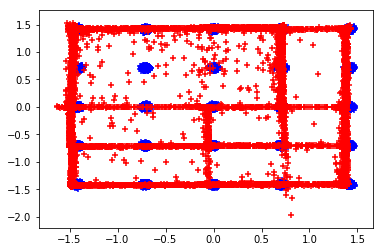

Epoch: 63/100, Step: 63500, D Loss: 0.9299913048744202, G Loss: 1.4587767124176025


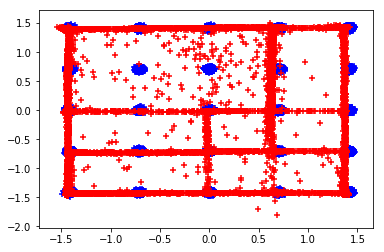

Epoch: 64/100, Step: 64000, D Loss: 0.8684075474739075, G Loss: 1.5873358249664307


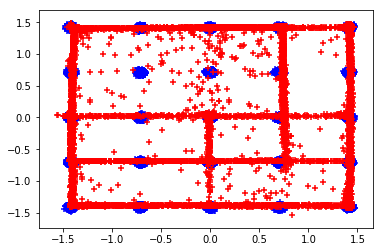

Epoch: 64/100, Step: 64500, D Loss: 0.9064438343048096, G Loss: 1.3982000350952148


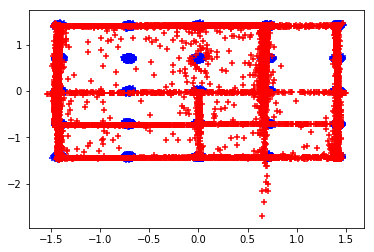

Epoch: 65/100, Step: 65000, D Loss: 0.9252493977546692, G Loss: 1.162602186203003


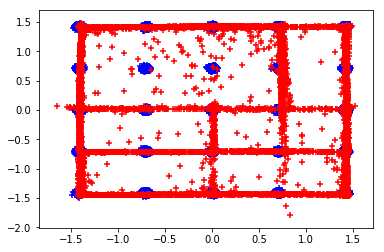

Epoch: 65/100, Step: 65500, D Loss: 0.9420865774154663, G Loss: 1.3117849826812744


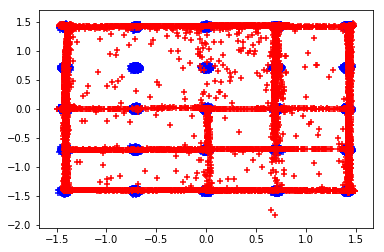

Epoch: 66/100, Step: 66000, D Loss: 0.8944165706634521, G Loss: 1.4777848720550537


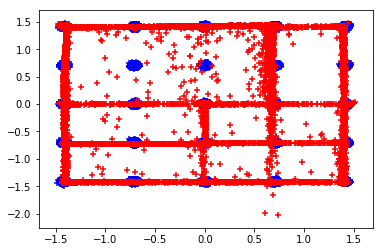

Epoch: 66/100, Step: 66500, D Loss: 0.9752100706100464, G Loss: 1.3752832412719727


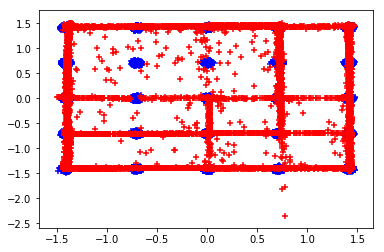

Epoch: 67/100, Step: 67000, D Loss: 0.9304014444351196, G Loss: 1.4621727466583252


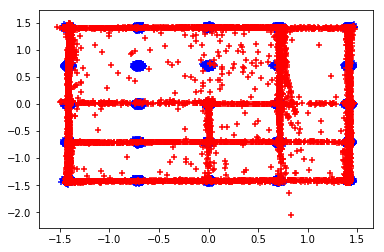

Epoch: 67/100, Step: 67500, D Loss: 0.9376392364501953, G Loss: 1.6294124126434326


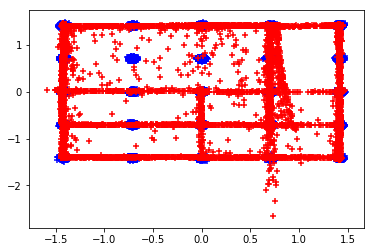

Epoch: 68/100, Step: 68000, D Loss: 0.9281613230705261, G Loss: 1.5864981412887573


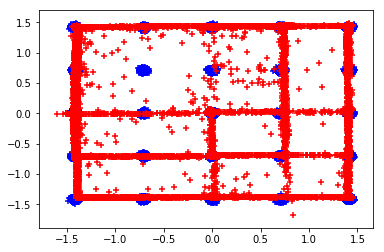

Epoch: 68/100, Step: 68500, D Loss: 0.9208400845527649, G Loss: 1.1849044561386108


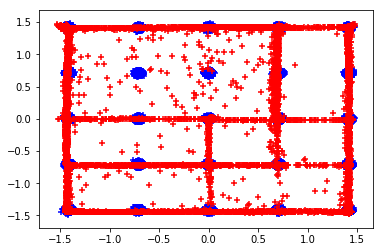

Epoch: 69/100, Step: 69000, D Loss: 1.0025396347045898, G Loss: 1.549672245979309


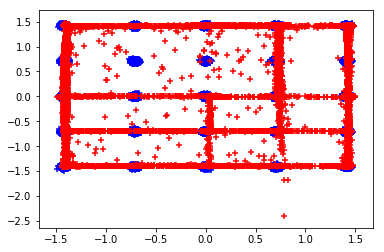

Epoch: 69/100, Step: 69500, D Loss: 0.9353576302528381, G Loss: 1.2275197505950928


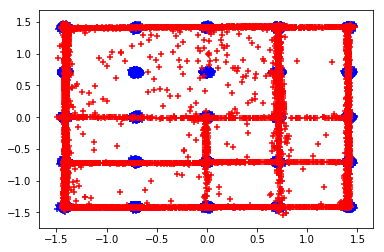

Epoch: 70/100, Step: 70000, D Loss: 0.9090220332145691, G Loss: 1.394026517868042


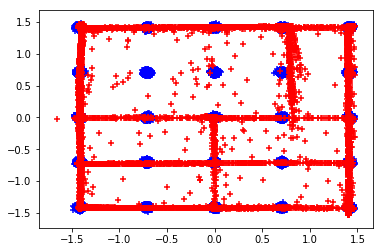

Epoch: 70/100, Step: 70500, D Loss: 0.9139018058776855, G Loss: 1.4619126319885254


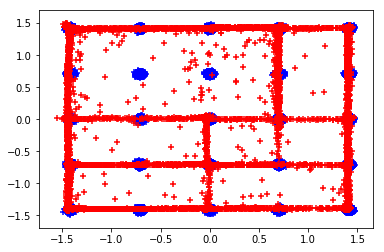

Epoch: 71/100, Step: 71000, D Loss: 0.9080237150192261, G Loss: 1.4414983987808228


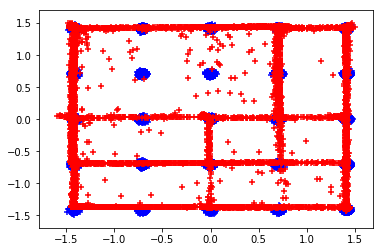

Epoch: 71/100, Step: 71500, D Loss: 0.9399844408035278, G Loss: 1.1762237548828125


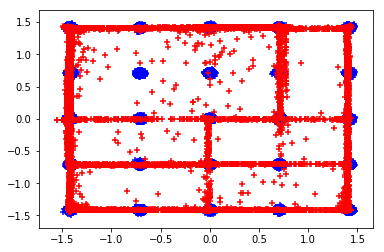

Epoch: 72/100, Step: 72000, D Loss: 0.9322257041931152, G Loss: 1.3785693645477295


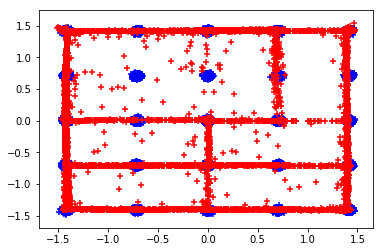

Epoch: 72/100, Step: 72500, D Loss: 0.8779694437980652, G Loss: 1.183763027191162


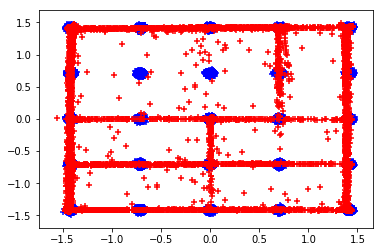

Epoch: 73/100, Step: 73000, D Loss: 0.9084853529930115, G Loss: 1.4214425086975098


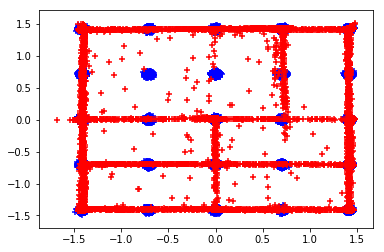

Epoch: 73/100, Step: 73500, D Loss: 0.9240987300872803, G Loss: 1.1947321891784668


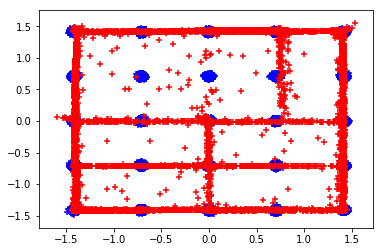

Epoch: 74/100, Step: 74000, D Loss: 1.0132145881652832, G Loss: 1.5013413429260254


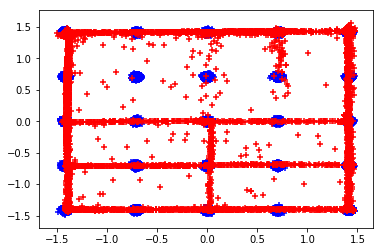

Epoch: 74/100, Step: 74500, D Loss: 0.9246626496315002, G Loss: 1.444462537765503


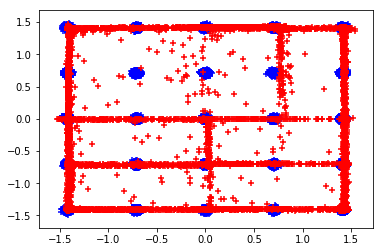

Epoch: 75/100, Step: 75000, D Loss: 0.9694055318832397, G Loss: 1.365185260772705


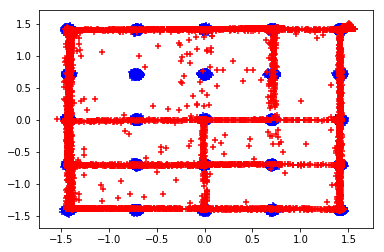

Epoch: 75/100, Step: 75500, D Loss: 0.9679193496704102, G Loss: 1.4177908897399902


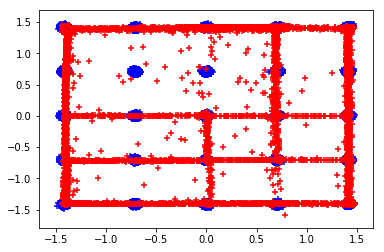

Epoch: 76/100, Step: 76000, D Loss: 1.0120265483856201, G Loss: 1.3162906169891357


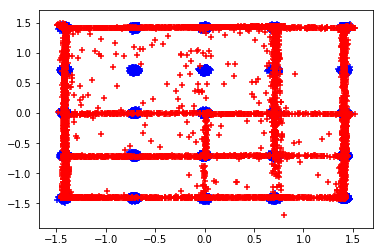

Epoch: 76/100, Step: 76500, D Loss: 0.9614073634147644, G Loss: 1.4315154552459717


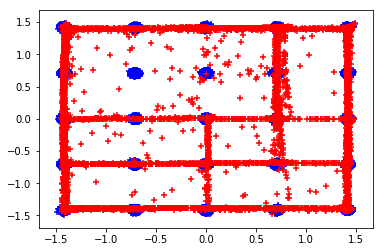

Epoch: 77/100, Step: 77000, D Loss: 0.9333791136741638, G Loss: 1.2917145490646362


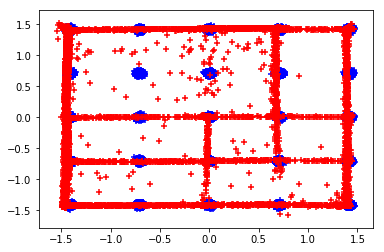

Epoch: 77/100, Step: 77500, D Loss: 0.8945245146751404, G Loss: 1.238473653793335


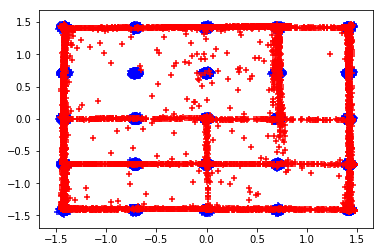

Epoch: 78/100, Step: 78000, D Loss: 0.9003450274467468, G Loss: 1.2886419296264648


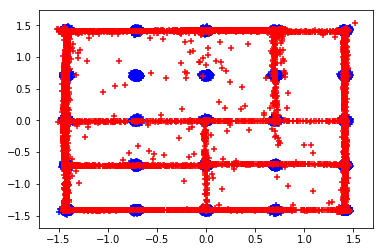

Epoch: 78/100, Step: 78500, D Loss: 0.9168801307678223, G Loss: 1.1899447441101074


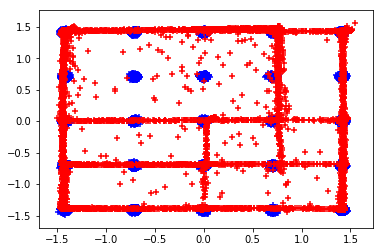

Epoch: 79/100, Step: 79000, D Loss: 0.9674838781356812, G Loss: 1.5007736682891846


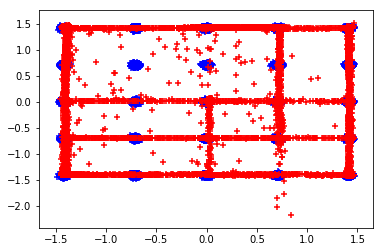

Epoch: 79/100, Step: 79500, D Loss: 1.091245174407959, G Loss: 1.3034157752990723


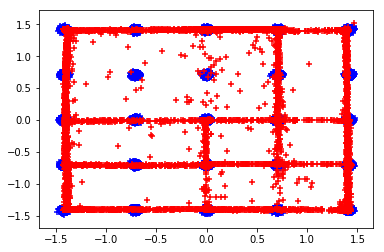

Epoch: 80/100, Step: 80000, D Loss: 0.883507490158081, G Loss: 1.3824248313903809


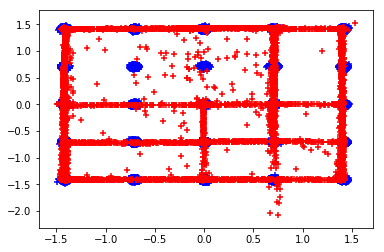

Epoch: 80/100, Step: 80500, D Loss: 0.9597212076187134, G Loss: 1.5976309776306152


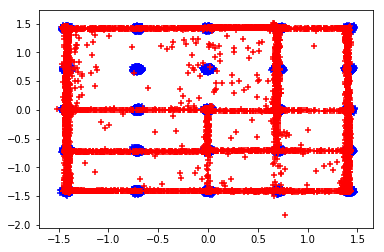

Epoch: 81/100, Step: 81000, D Loss: 0.9194915294647217, G Loss: 1.370643138885498


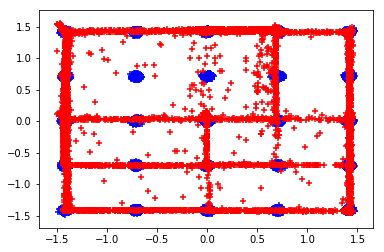

Epoch: 81/100, Step: 81500, D Loss: 0.9963089227676392, G Loss: 1.319279432296753


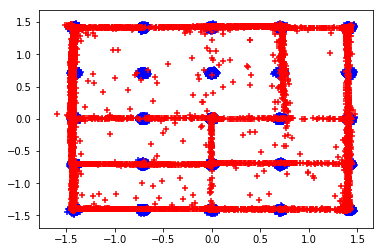

Epoch: 82/100, Step: 82000, D Loss: 0.8876529932022095, G Loss: 1.3359782695770264


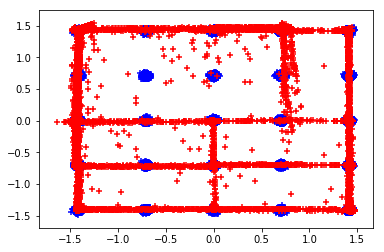

Epoch: 82/100, Step: 82500, D Loss: 0.9839729070663452, G Loss: 1.6686304807662964


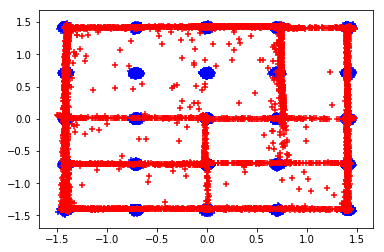

Epoch: 83/100, Step: 83000, D Loss: 0.9455208778381348, G Loss: 1.3633296489715576


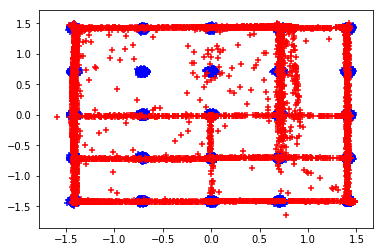

Epoch: 83/100, Step: 83500, D Loss: 0.988960862159729, G Loss: 1.2518768310546875


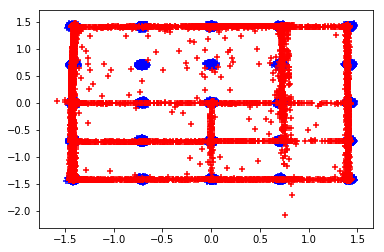

Epoch: 84/100, Step: 84000, D Loss: 0.9289068579673767, G Loss: 1.4499925374984741


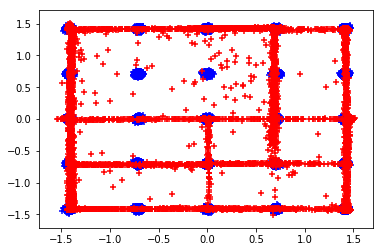

Epoch: 84/100, Step: 84500, D Loss: 0.9580094814300537, G Loss: 1.3464055061340332


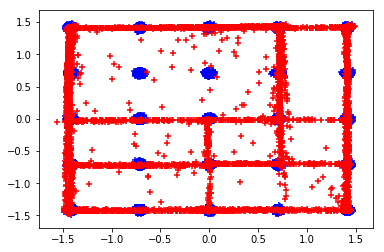

Epoch: 85/100, Step: 85000, D Loss: 0.9139469265937805, G Loss: 1.3576796054840088


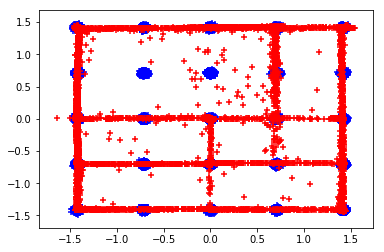

Epoch: 85/100, Step: 85500, D Loss: 0.9430255889892578, G Loss: 1.1695523262023926


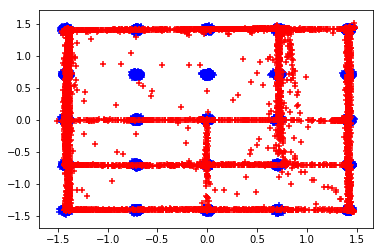

Epoch: 86/100, Step: 86000, D Loss: 0.9541457295417786, G Loss: 1.29864501953125


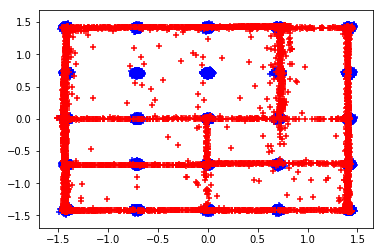

Epoch: 86/100, Step: 86500, D Loss: 1.0731464624404907, G Loss: 1.4819554090499878


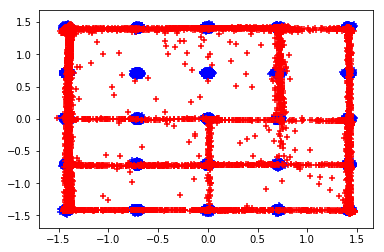

Epoch: 87/100, Step: 87000, D Loss: 0.971947431564331, G Loss: 1.4812899827957153


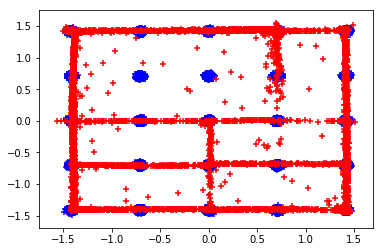

Epoch: 87/100, Step: 87500, D Loss: 0.9805103540420532, G Loss: 1.2918384075164795


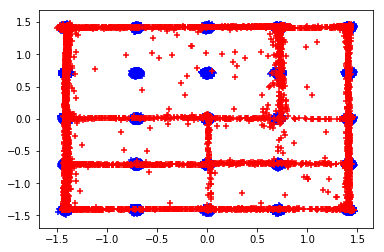

Epoch: 88/100, Step: 88000, D Loss: 0.8317511081695557, G Loss: 1.521686315536499


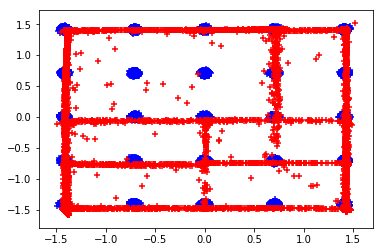

Epoch: 88/100, Step: 88500, D Loss: 0.8914732336997986, G Loss: 1.1717429161071777


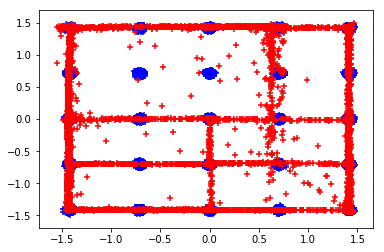

Epoch: 89/100, Step: 89000, D Loss: 1.0056167840957642, G Loss: 1.3305072784423828


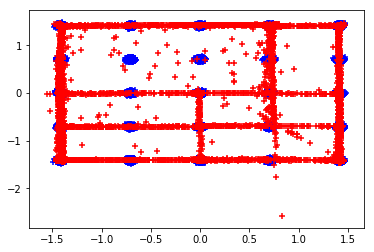

Epoch: 89/100, Step: 89500, D Loss: 0.9281089901924133, G Loss: 1.3957083225250244


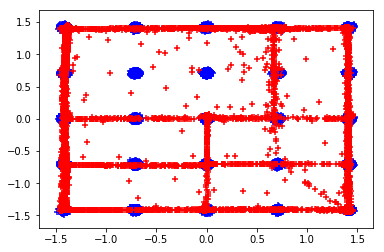

Epoch: 90/100, Step: 90000, D Loss: 0.8549594879150391, G Loss: 1.318182110786438


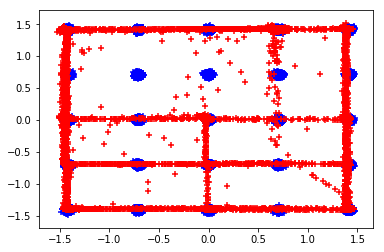

Epoch: 90/100, Step: 90500, D Loss: 0.9641065001487732, G Loss: 1.2531119585037231


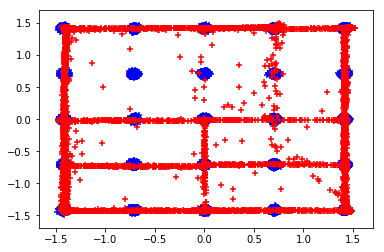

Epoch: 91/100, Step: 91000, D Loss: 0.9459869861602783, G Loss: 1.340721845626831


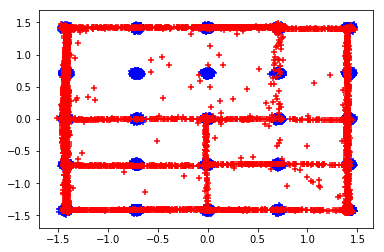

Epoch: 91/100, Step: 91500, D Loss: 0.9918183088302612, G Loss: 1.2697064876556396


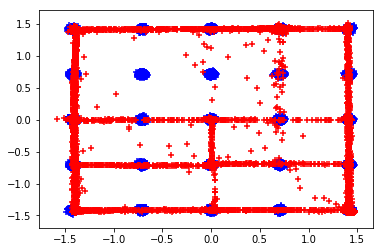

Epoch: 92/100, Step: 92000, D Loss: 0.9843209981918335, G Loss: 1.6979113817214966


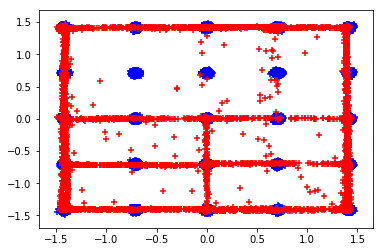

Epoch: 92/100, Step: 92500, D Loss: 0.8969936370849609, G Loss: 1.3752281665802002


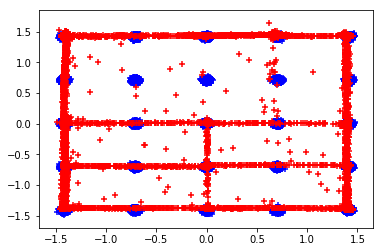

Epoch: 93/100, Step: 93000, D Loss: 0.9799612760543823, G Loss: 1.4840598106384277


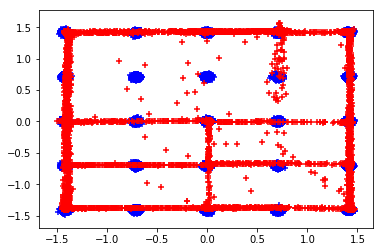

Epoch: 93/100, Step: 93500, D Loss: 0.836298942565918, G Loss: 1.2119808197021484


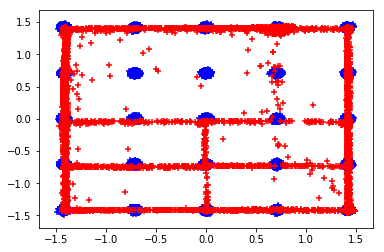

Epoch: 94/100, Step: 94000, D Loss: 0.9335514307022095, G Loss: 1.3156267404556274


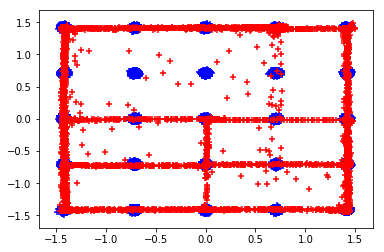

Epoch: 94/100, Step: 94500, D Loss: 1.0227563381195068, G Loss: 1.5161094665527344


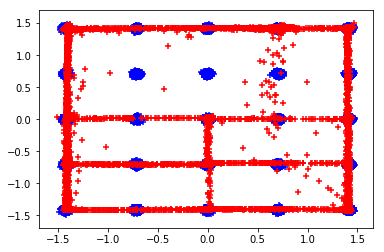

Epoch: 95/100, Step: 95000, D Loss: 0.8738878965377808, G Loss: 1.3777620792388916


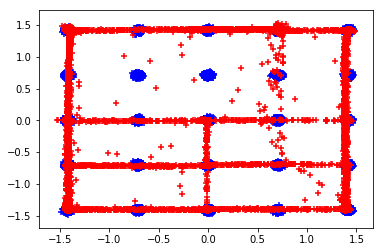

Epoch: 95/100, Step: 95500, D Loss: 0.9237127304077148, G Loss: 1.2925761938095093


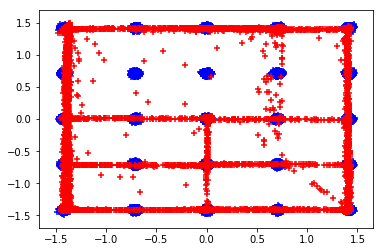

Epoch: 96/100, Step: 96000, D Loss: 0.868964672088623, G Loss: 1.2056025266647339


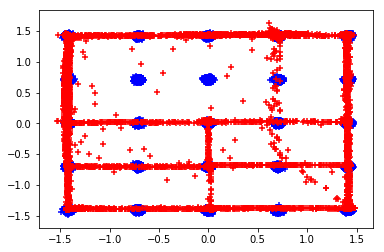

Epoch: 96/100, Step: 96500, D Loss: 0.9508965611457825, G Loss: 1.55659019947052


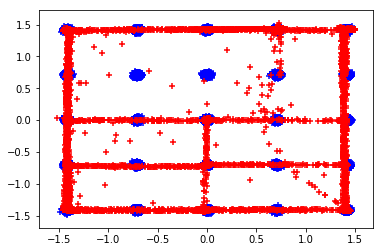

Epoch: 97/100, Step: 97000, D Loss: 0.9716957807540894, G Loss: 1.3170268535614014


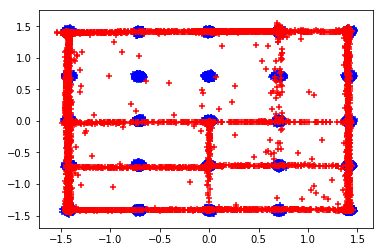

Epoch: 97/100, Step: 97500, D Loss: 0.9353993535041809, G Loss: 1.2786940336227417


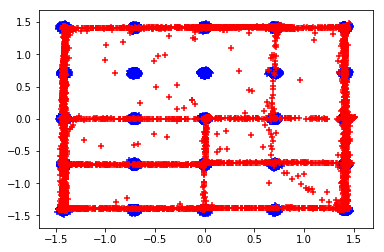

Epoch: 98/100, Step: 98000, D Loss: 0.9566564559936523, G Loss: 1.3089005947113037


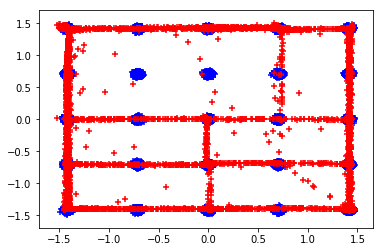

Epoch: 98/100, Step: 98500, D Loss: 0.9162840843200684, G Loss: 1.883226990699768


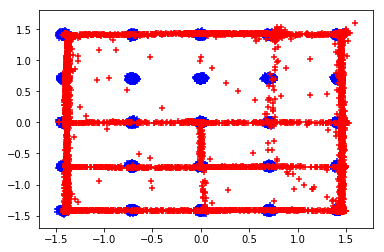

Epoch: 99/100, Step: 99000, D Loss: 0.9438337087631226, G Loss: 1.371001958847046


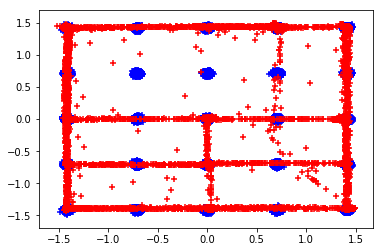

Epoch: 99/100, Step: 99500, D Loss: 0.9693731665611267, G Loss: 1.3707053661346436


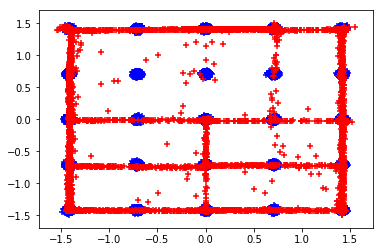

In [11]:
for epoch in range(max_epoch):
    for idx, x in enumerate(train):
        # Training Discriminator
        
        x = torch.Tensor(x)

        if DEVICE == torch.device("cuda"):
            x = x.cuda()
        
        x = torch.autograd.Variable(x)  
        x_outputs = D(x)      

        D_x_loss = criterion(x_outputs, D_labels)


        z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
            generate_image(train)
        step += 1